<a href="https://colab.research.google.com/github/rainmaker29/Introduction-to-Tensorflow/blob/master/rnn_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

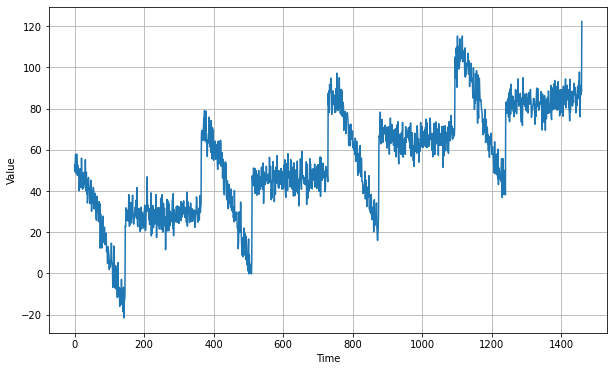

In [2]:
#setup cell
# All this code comes from the first notebook of forecasting so its all copy paste
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [4]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train,window_size,batch_size=128)


model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 32ms/step - loss: 48.7702 - mae: 50.7167 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 23.6083 - mae: 23.4932 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 19.2203 - mae: 19.7003 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 16.9138 - mae: 17.4605 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 29ms/step - loss: 15.4832 - mae: 15.8988 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 14.8246 - mae: 15.2367 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 14.1447 - mae: 14.7931 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 30ms/step - loss: 13.7984 - mae: 14.5512 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 28ms/step - loss: 13.6220 - mae: 14.2687 - lr: 2.5

(1e-07, 0.0001, 0.0, 30.0)

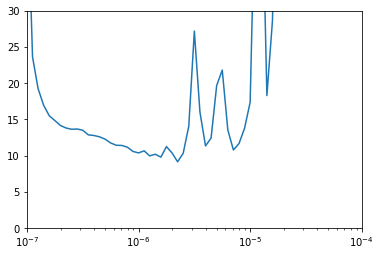

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      7/Unknown - 0s 30ms/step - loss: 57.3394 - mae: 57.8379WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 386ms/step - loss: 53.3189 - mae: 55.3843 - val_loss: 53.2415 - val_mae: 54.2733
Epoch 2/500
8/8 [==============================] - 3s 356ms/step - loss: 35.4459 - mae: 35.9565 - val_loss: 17.1286 - val_mae: 18.0162
Epoch 3/500
8/8 [==============================] - 0s 41ms/step - loss: 22.2280 - mae: 23.0386 - val_loss: 18.8781 - val_mae: 19.3139
Epoch 4/500
8/8 [==============================] - 0s 42ms/step - loss: 16.0123 - mae: 16.7054 - val_loss: 20.4111 - val_m

In [0]:
model = keras.models.load_model("my_checkpoint")

In [0]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

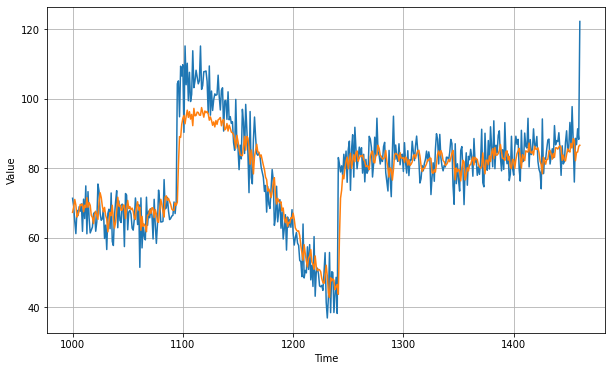

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [10]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.324788

In [0]:
#seq2seq
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 31ms/step - loss: 51.2841 - mae: 52.8611 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 25.9057 - mae: 25.9671 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 23.3706 - mae: 23.9971 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 20.9733 - mae: 21.6294 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 29ms/step - loss: 19.4552 - mae: 19.9674 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 18.6737 - mae: 19.1647 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 30ms/step - loss: 18.0822 - mae: 18.6587 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 30ms/step - loss: 17.6896 - mae: 18.2568 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 32ms/step - loss: 17.2787 - mae: 17.9280 - lr: 1.8

(1e-07, 0.0001, 0.0, 30.0)

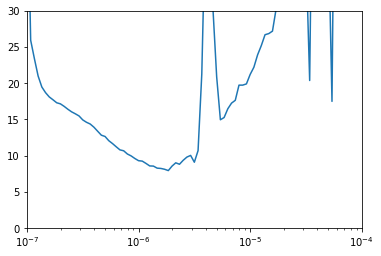

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 75ms/step - loss: 54.0380 - mae: 54.6412 - val_loss: 18.0319 - val_mae: 18.4157
Epoch 2/500
8/8 [==============================] - 0s 46ms/step - loss: 33.8215 - mae: 34.6694 - val_loss: 20.2545 - val_mae: 21.0440
Epoch 3/500
8/8 [==============================] - 0s 44ms/step - loss: 27.3035 - mae: 28.0027 - val_loss: 37.7293 - val_mae: 38.3705
Epoch 4/500
8/8 [==============================] - 0s 43ms/step - loss: 20.9165 - mae: 21.5578 - val_loss: 25.2244 - val_mae: 25.7674
Epoch 5/500
8/8 [==============================] - 0s 43ms/step - loss: 17.1504 - mae: 17.6667 - val_loss: 15.3145 - val_mae: 15.8504
Epoch 6/500
8/8 [==============================] - 0s 44ms/step - loss: 15.0022 - mae: 15.5247 - val_loss: 9.6922 - val_mae: 9.9070
Epoch 7/500
8/8 [==============================] - 0s 44ms/step - loss: 13.8390 - mae: 14.4372 - val_loss: 9.0024 - val_mae: 9.6475
Epoch 8/500
8/8 [==============================] - 0s 46ms/step - 

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

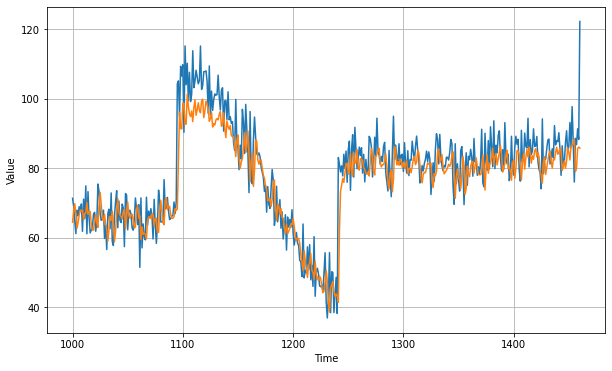

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [18]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.458873